In [ ]:
import numpy as np

## Defining Brownian Motion Function and Simulating Initial Haircuts

In [ ]:
from math import sqrt
from scipy.stats import norm

np.random.seed(2)

# Credit: https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html
def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.

    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.

    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples.
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

In [ ]:
T = 120 / 365
n = 2400
dt = T / n

treasury_drift = 0
treasury_vol = 0.5

# during 1: normal. immediately after 1: artificially inflate drift and vol of a risky asset. during 2: normal.
treasury_wiener1 = brownian(0, n, dt, 1)
treasury_wiener2 = brownian(0, n, dt, 1)

treasury_wiener = np.concatenate((treasury_wiener1, treasury_wiener2))

treasury_haircuts = np.exp(T * (treasury_drift - 0.5*(treasury_vol**2)) + treasury_vol * treasury_wiener)
treasury_haircuts[-1]

np.float64(0.8029694672247997)

In [ ]:
assets = 20
correlations = np.array([0.7 for _ in range(assets)])
volatilties = np.array([1 for _ in range(assets)])
drifts = np.array([0 for _ in range(assets)])
starting_points = np.array([5 for _ in range(assets)])

assets_wieners1 = np.array([treasury_wiener1 * correlations[i] + np.sqrt(1-(correlations[i])**2) * brownian(0, n, dt, 1) for i in range(assets)])
assets_haircuts1 = np.exp(np.array([np.log(starting_points[i]) + T * (drifts[i] - 0.5 * (volatilties[i]) ** 2) + volatilties[i] * assets_wieners1[i] for i in range(assets)]))

assets_haircuts1[:,-1]

array([1.28705263, 2.39319696, 2.64516968, 5.09252393, 6.17245975,
       2.43816586, 3.00410651, 2.68567284, 1.6309903 , 1.42402879,
       3.19074062, 4.12119776, 3.39088644, 2.804136  , 2.90450977,
       5.2593608 , 1.9055498 , 1.94626663, 1.46894403, 2.16483039])

## Artificially Inflating Idiosyncratic Drift for Asset 0

In [ ]:
asset_index = 0 # index of asset to artificially inflate
drifts[asset_index] = 5
volatilties[asset_index] *= 1
starting_points = assets_haircuts1[:,-1]

assets_wieners2 = np.array([treasury_wiener2 * correlations[i] + np.sqrt(1-(correlations[i])**2) * brownian(0, n, dt, 1) for i in range(assets)])
assets_haircuts2 = np.exp(np.array([np.log(starting_points[i]) + T * (drifts[i] - 0.5 * (volatilties[i]) ** 2) + volatilties[i] * assets_wieners2[i] for i in range(assets)]))

assets_haircuts2[:,-1]

array([6.84906014, 0.99837436, 1.48708266, 1.99449796, 3.84412203,
       1.62462439, 1.95596816, 0.77707826, 1.37143291, 1.24534991,
       1.84387928, 2.0217672 , 2.06726198, 1.08874996, 1.32852405,
       2.64746584, 1.2692956 , 1.11454138, 1.46168335, 1.86960098])

The vector below now contains the complete simulated asset haircuts

In [ ]:
assets_haircuts = np.array([np.concatenate((assets_haircuts1[i], assets_haircuts2[i])) for i in range(assets)])

In [ ]:
assets_haircuts.shape

(20, 4800)

# Running the Spike Detection Algorithm

Compute **daily** Treasury and risky asset haircut rates from Monte Carlo quasi-continuous time-series

In [ ]:
day_window = int(T / (dt * 120))
daily_treasury_haircuts = np.array([np.mean(treasury_haircuts[i*day_window:(i+1)*day_window]) for i in range(int(treasury_haircuts.shape[0] / day_window))])
daily_assets_haircuts_arr = []
for i in range(assets):
  asset_haircuts = assets_haircuts[i]
  daily_asset_haircuts = np.array([asset_haircuts[(i+1)*day_window - 1] for i in range(int(asset_haircuts.shape[0] / day_window))])
  daily_assets_haircuts_arr.append(daily_asset_haircuts)

daily_assets_haircuts = np.array(daily_assets_haircuts_arr)


## Computing and Plotting Treasury Betas

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg_window = 7 # in days
lin_reg_treasury_haircuts = daily_treasury_haircuts.reshape(-1, 1)

treasury_betas = np.zeros((assets, daily_treasury_haircuts.shape[0]))

for i in range(assets):
  lin_reg_asset_haircuts = daily_assets_haircuts[i].reshape(-1, 1)
  for j in range(lin_reg_window, daily_treasury_haircuts.shape[0]):
    X = lin_reg_treasury_haircuts[j-lin_reg_window:j]
    Y = lin_reg_asset_haircuts[j-lin_reg_window:j]
    model = LinearRegression(fit_intercept=False).fit(X, Y)
    beta = model.coef_
    treasury_betas[i, j] = beta.item()

These serve `matplotlib` color and linestyle configurations, to ensure reader accessibility.

In [ ]:
import matplotlib as plt

In [ ]:
colors = ["#1F4E4A", "#0072B2","#D55E00", "#009E73", "#CC79A7","#56B4E9"]
linestyles = ['-', '-.', '--', '--', (0, (5, 1)), (0, (3, 1, 1, 1))]

plt.rcParams.update({
  "font.size": 11,
  "axes.labelsize": 11,
  "axes.titlesize": 12,
  "legend.fontsize": 10,
  "xtick.labelsize": 10,
  "ytick.labelsize": 10
})

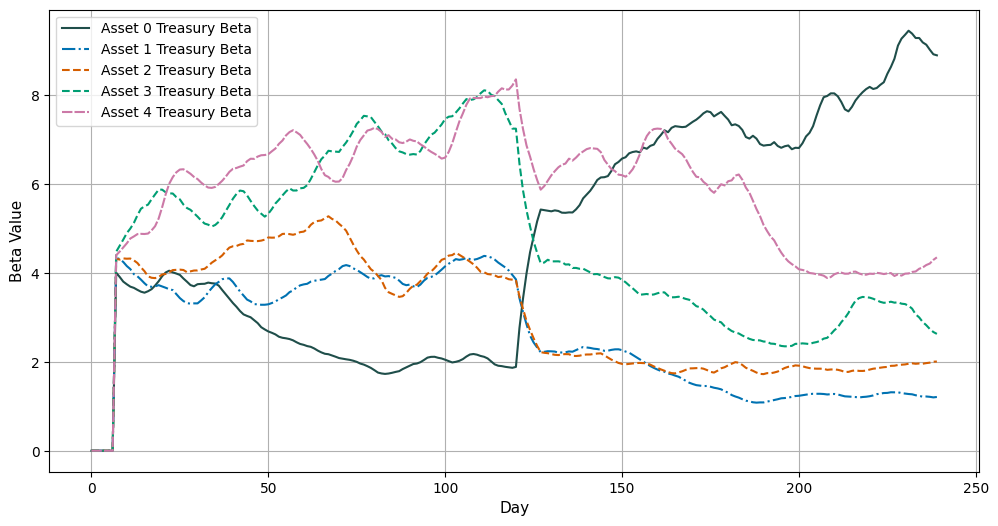

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(5):
  plt.plot(treasury_betas[i], label=f"Asset {str(i)} Treasury Beta", linestyle=linestyles[i], color=colors[i])

plt.xlabel('Day')
plt.ylabel('Beta Value')
plt.grid(True)
plt.legend()
plt.show()

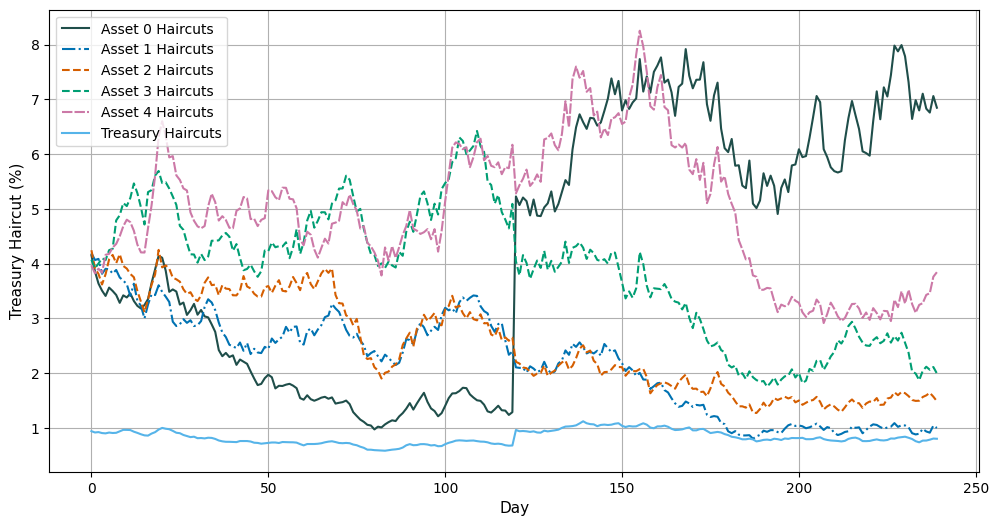

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(5):
  plt.plot(daily_assets_haircuts[i], label=f"Asset {str(i)} Haircuts", linestyle=linestyles[i], color=colors[i])

plt.plot(daily_treasury_haircuts, label="Treasury Haircuts", color=colors[5])

plt.xlabel('Day')
plt.ylabel('Treasury Haircut (%)')
plt.grid(True)
plt.legend()
plt.show()

## Computing Beta Matrix

In [ ]:
beta_matrices = np.zeros((daily_treasury_haircuts.shape[0], assets, assets))

In [ ]:
daily_assets_haircuts.shape

(20, 240)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg_window = 7 # in days

for t in range(lin_reg_window-1, daily_assets_haircuts.shape[1]):
  for i in range(assets):
    asset_haircuts_i = daily_assets_haircuts[i, (t - lin_reg_window + 1):(t + 1)].reshape(-1,1)
    for j in range(assets):
      if j == i:
        beta_matrices[t,i,j] = 1
        continue
      asset_haircuts_j = daily_assets_haircuts[j, (t - lin_reg_window + 1):(t + 1)].reshape(-1, 1)
      model = LinearRegression(fit_intercept=False).fit(asset_haircuts_j, asset_haircuts_i)
      beta = model.coef_.item()
      beta_matrices[t,i,j] = beta

## Computing Exponential Beta Matrices Average

In [ ]:
beta_matrices_avg = np.zeros((daily_treasury_haircuts.shape[0], assets, assets))
exponential_weight = 0.05

In [ ]:
for t in range(lin_reg_window-1, beta_matrices_avg.shape[0]):
  if t == lin_reg_window-1:
    beta_matrix_avg = beta_matrices[t]
  else:
    prev_beta_matrix_avg = beta_matrices_avg[t - 1]
    beta_matrix_avg = exponential_weight * beta_matrices[t] + (1-exponential_weight) * prev_beta_matrix_avg
  beta_matrices_avg[t] = beta_matrix_avg

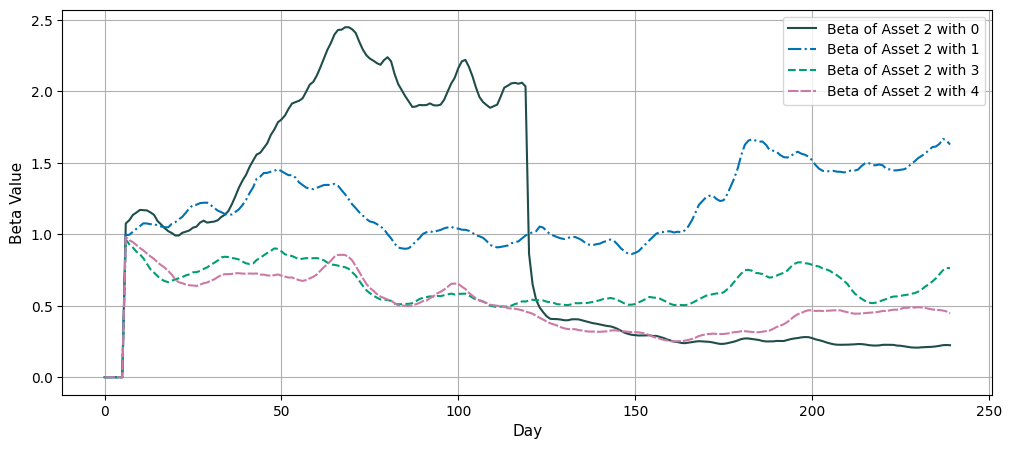

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

example_asset = 2

for i in range(5):
  if i == example_asset:
    continue
  plt.plot(beta_matrices[:,example_asset,i], label=f"Beta of Asset {str(example_asset)} with {str(i)}", linestyle=linestyles[i], color=colors[i])

plt.xlabel('Day')
plt.ylabel('Beta Value')
plt.grid(True)
plt.legend()
plt.show()

## Beta Distance Calculation

In [ ]:
distances = np.zeros((assets, daily_assets_haircuts.shape[1]))

In [ ]:
for i in range(assets):
  for t in range(daily_assets_haircuts.shape[1]):
    if t >= lin_reg_window:
      distance = (1 / (assets - 1)) * np.linalg.norm(beta_matrices[t, i] - beta_matrices_avg[t-1, i])
      distances[i,t] = distance

In [ ]:
distances[0, 123]

np.float64(0.21540307745748286)

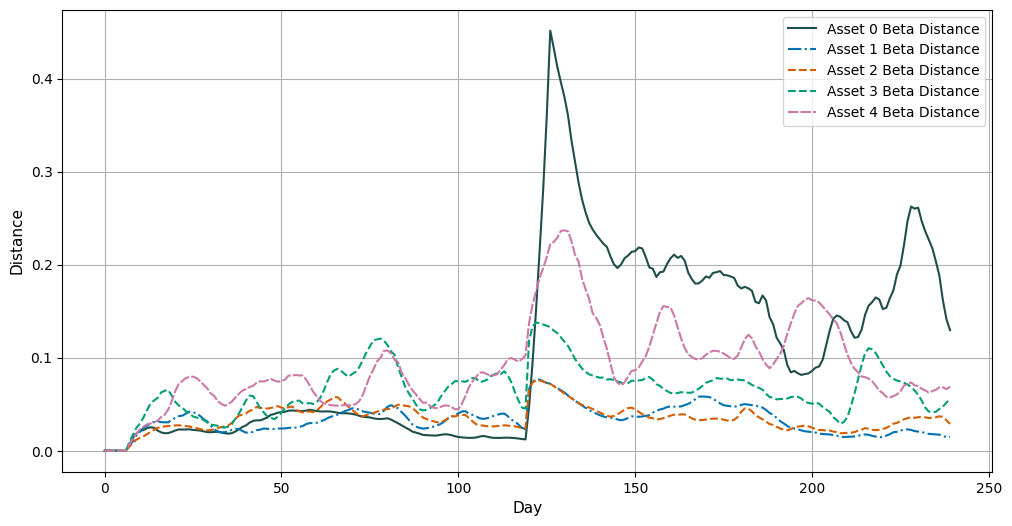

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(5):
  plt.plot(distances[i], label=f"Asset {str(i)} Beta Distance", linestyle=linestyles[i], color=colors[i])

plt.xlabel('Day')
plt.ylabel('Distance')
plt.grid(True)
plt.legend()
plt.show()

## Spike Detection

In [ ]:
import pandas as pd

z_score_window = 10
spikes = 0

distances_spikes = np.zeros((assets, distances.shape[1]))

for i in range(assets):
  for t in range(distances.shape[1]-1, -1, -1):
    if t - lin_reg_window < lin_reg_window:
      continue

    distances_i = distances[i]
    pd_distances_i = pd.Series(distances_i)

    mean = np.mean(distances_i[t-lin_reg_window:t])
    stddev = np.std(distances_i[t-lin_reg_window:t])

    if distances[i, t] > mean + 4 * stddev:
      distances_spikes[i, t] = 1

In [ ]:
import pandas as pd

z_score_window = 10
spikes = 0

finalized_spikes = np.zeros((assets, distances.shape[1]))

for i in range(assets):
  for t in range(daily_treasury_haircuts.shape[0]-1, -1, -1):
    if t - lin_reg_window < lin_reg_window:
      continue

    treasury_betas_i = treasury_betas[i]
    pd_treasury_betas_i = pd.Series(treasury_betas_i)

    mean = np.mean(treasury_betas_i[t-lin_reg_window:t])
    stddev = np.std(treasury_betas_i[t-lin_reg_window:t])

    if treasury_betas[i, t] > mean + 4 * stddev and distances_spikes[i, t] == 1:
      print(f"Spike: asset {i} at time {t}. Distance: {distances[i, t]}")
      finalized_spikes[i, t] = 1
      spikes += 1

Spike: asset 0 at time 122. Distance: 0.15279119533882124
Spike: asset 0 at time 121. Distance: 0.09480060258729761
Spike: asset 2 at time 62. Distance: 0.05028157818285855
Spike: asset 3 at time 63. Distance: 0.07445388188601497
Spike: asset 3 at time 62. Distance: 0.06478687878496237
Spike: asset 4 at time 103. Distance: 0.06831668701997803
Spike: asset 6 at time 43. Distance: 0.02570243394640333
Spike: asset 12 at time 40. Distance: 0.03202307299596286
Spike: asset 17 at time 177. Distance: 0.03582398707384083


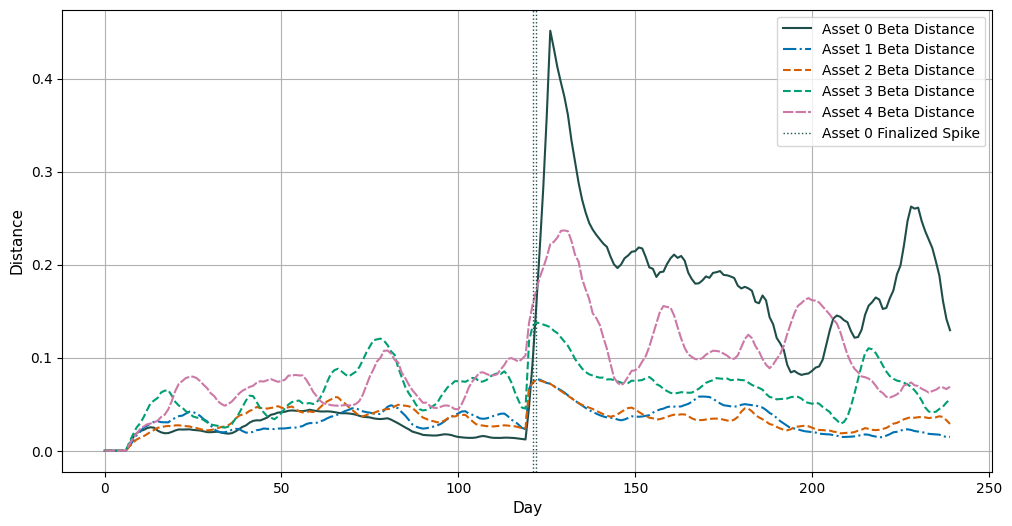

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(5):
  plt.plot(distances[i], label=f"Asset {str(i)} Beta Distance", linestyle=linestyles[i], color=colors[i])

spike_index = 0
for t in range(distances_spikes.shape[1]):
  if finalized_spikes[spike_index, t] == 1:
    plt.axvline(x=t, color=colors[spike_index], linestyle=':', linewidth=1, label=f'Asset {str(spike_index)} Finalized Spike' if t == np.where(finalized_spikes[spike_index] == 1)[0][0] else "") # Only label once

plt.xlabel('Day')
plt.ylabel('Distance')
plt.grid(True)
plt.legend()
plt.show()

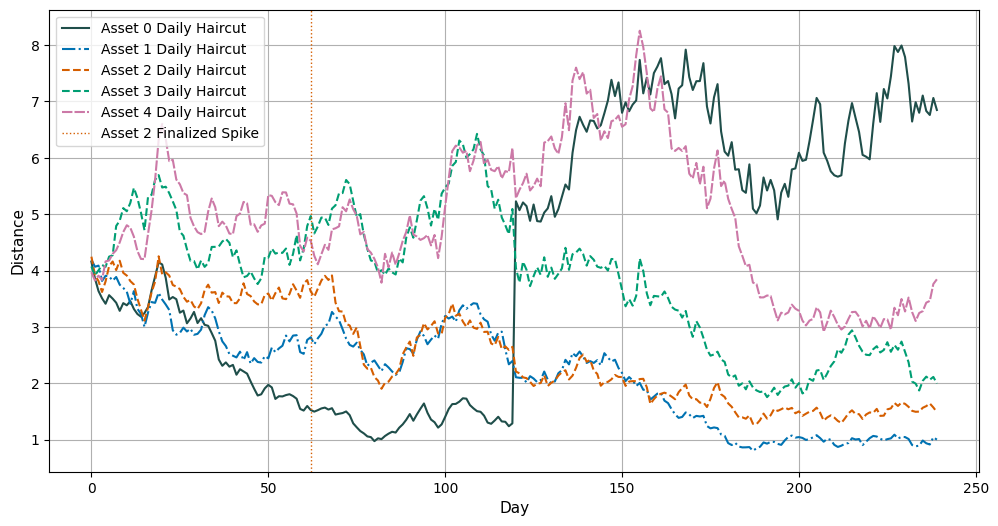

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(5):
  plt.plot(daily_assets_haircuts[i], label=f"Asset {str(i)} Daily Haircut", linestyle=linestyles[i], color=colors[i])

spike_index = 2
for t in range(distances_spikes.shape[1]):
  if finalized_spikes[spike_index, t] == 1:
    plt.axvline(x=t, color=colors[spike_index], linestyle=':', linewidth=1, label=f'Asset {str(spike_index)} Finalized Spike' if t == np.where(distances_spikes[spike_index] == 1)[0][0] else "") # Only label once

plt.xlabel('Day')
plt.ylabel('Distance')
plt.grid(True)
plt.legend()
plt.show()

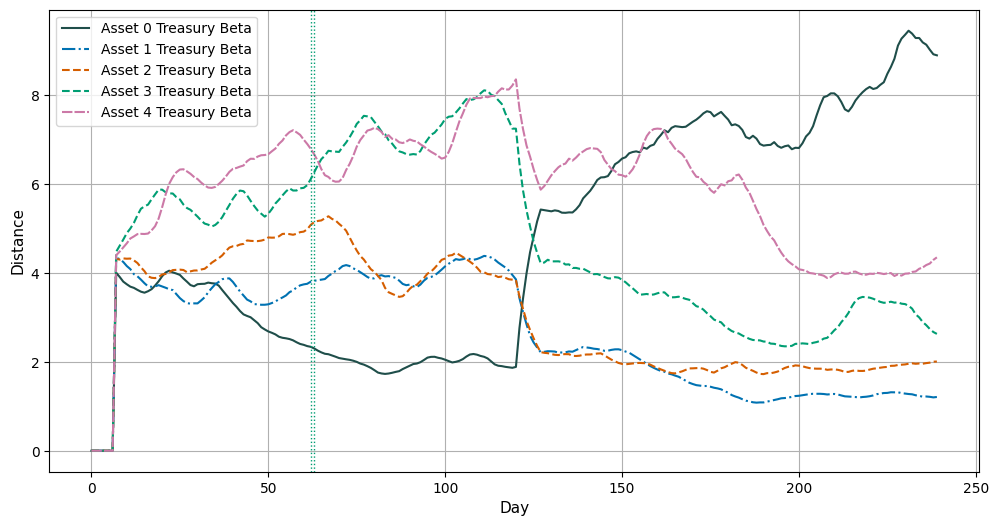

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(5):
  plt.plot(treasury_betas[i], label=f"Asset {str(i)} Treasury Beta", linestyle=linestyles[i], color=colors[i])

spike_index = 3
for t in range(distances_spikes.shape[1]):
  if finalized_spikes[spike_index, t] == 1:
    plt.axvline(x=t, color=colors[spike_index], linestyle=':', linewidth=1, label=f'Asset {str(spike_index)} Finalized Spike' if t == np.where(distances_spikes[spike_index] == 1)[0][0] else "") # Only label once

plt.xlabel('Day')
plt.ylabel('Distance')
plt.grid(True)
plt.legend()
plt.show()